# Supervised and Unsupervised Sentiment Analysis
## Data 622 Final Project

### Author: AJ Strauman-Scott
#### Date: December 18, 2024


# Introduction

This project investigates sentiment trends among Reddit users towards on the subjects of labor unions and labor strikes by using machine learning techniques to analyze user-generated forum content. By focusing on posts and comments from a diverse set of subreddits, I seek to capture a wide spectrum of political opinions and explore the dynamics of online discourse on these critical labor topics. I employ both a custom-trained Naive Bayes model and an industry-standard RoBERTa transformer model. The comparative analysis of these models serves as a foundation for more advanced explorations, including clustering and dynamic topic modeling.

My primary objective is to identify and understand sentiment trends while assessing the relative performance of simpler, interpretable models against sophisticated, pre-trained transformer-based architectures. This work not only offers insights into the role of unions and strikes in contemporary public opinion but also evaluates the effectiveness of different machine learning approaches in processing and analyzing large, noisy datasets. 

# Data Source and Description

The data for this study were manually scraped from Reddit, focusing on subreddits that encompass a wide range of political perspectives, such as "Conservative," "liberal," "Libertarian," "progressive," and topic-specific communities like "antiwork," "Strikes," and "BlueCollarWomen." This selection ensures a broad and balanced representation of opinions on labor-related issues. Posts and comments containing keywords "union" or "strike" were collected, yielding a dataset of 14,316 observations.

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.amp import GradScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
    silhouette_score,
)
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from datasets import Dataset
from scipy.special import softmax
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from transformers.models.roberta.modeling_roberta import RobertaClassificationHead
from transformers import (
    get_scheduler,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    RobertaConfig,
)
import torch.optim as optim

Although posts and comments were filtered before scraping to include the word 'union' or strike, the dataset still has some entries referred to unrelated contexts, such as military strikes or the Soviet Union. These entries were filtered out using keywords 'Israel', 'drone' and 'Soviet'. After preprocessing and filtering, the dataset represents a rich corpus of user-generated content spanning various socioeconomic and ideological contexts.

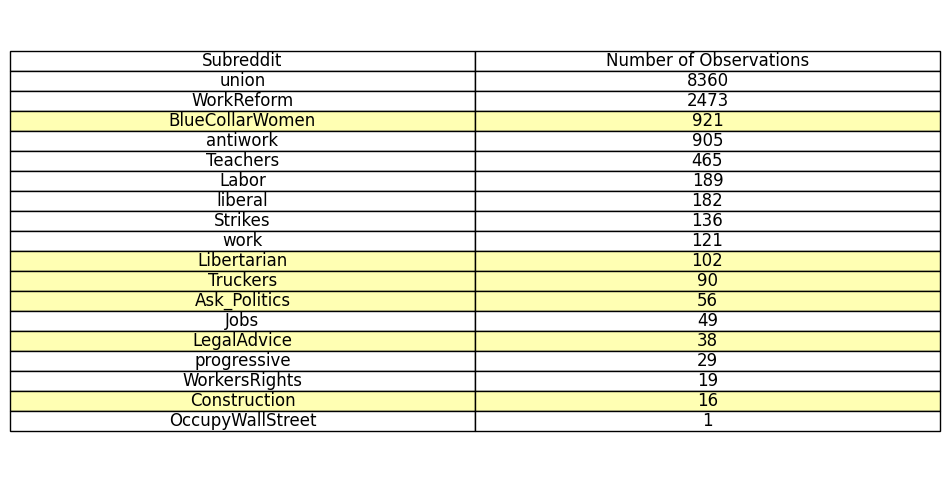

In [2]:
# Load manually labelled data sample
pickle_folder = "/Users/seshat/Documents/GitHub/labor_sentiment_analysis/data/pickle"
pickle_path = os.path.join(pickle_folder, "reddit_labelled-sample.pkl")
reddit = joblib.load(pickle_path)

# Load full dataset
pickle_path = os.path.join(pickle_folder, "reddit.pkl")
reddit_full = joblib.load(pickle_path)

# Define filter words
filter_words = ["israel", "drone", "soviet"]
def contains_filter_words(text):
    return any(word in text.lower() for word in filter_words)

# Filter the datasets
reddit = reddit[~reddit["text"].apply(contains_filter_words)].drop_duplicates()
reddit_full = reddit_full[~reddit_full["text"].apply(contains_filter_words)].drop_duplicates()

# Count observations for each subreddit
subreddit_counts = reddit_full["subreddit"].value_counts()

subreddit_counts_df = subreddit_counts.reset_index()
subreddit_counts_df.columns = ["Subreddit", "Number of Observations"]

highlighted_subreddits = [
    "BlueCollarWomen",
    "Libertarian",
    "Truckers",
    "Construction",
    "LegalAdvice",
    "Ask_Politics",
    "jobs",
]

# Plotting the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("tight")
ax.axis("off")

table = ax.table(
    cellText=subreddit_counts_df.values,
    colLabels=subreddit_counts_df.columns,
    cellLoc="center",
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Highlight rows
for i, row in enumerate(subreddit_counts_df["Subreddit"]):
    if row in highlighted_subreddits:
        for j in range(len(subreddit_counts_df.columns)):
            table[(i + 1, j)].set_facecolor(
                "#ffffb3"
            ) 

plt.show()

# Methodology

I adopted a supervised learning approach to classify sentiments in the dataset, complemented by unsupervised techniques to explore clustering and topic modeling. A randomly selected subset of 1,600 observations was manually labeled for initial model training. Using this labeled data, I trained a custom Naive Bayes classifier, employing techniques like TF-IDF vectorization and hyperparameter tuning to optimize performance.

Concurrently, I fine-tuned a RoBERTa transformer model, leveraging its pre-trained embeddings for both classification and downstream clustering tasks. The labeled dataset was split into training and testing subsets, ensuring a fair evaluation of model performance. Both models were then used to label the entire dataset.

To further analyze the data, I employed RoBERTa embeddings as input for unsupervised clustering algorithms, including K-Means and a Deep Clustering with Semantic Contrastive Learning (DCSC) model. This hybrid approach aimed to uncover latent groupings within the data and provide a foundation for dynamic topic modeling using Latent Dirichlet Allocation (LDA).

The analysis pipeline included:

    Preprocessing: Tokenization, lemmatization, and removal of irrelevant content.
    Model Training: Custom Naive Bayes and RoBERTa models, with hyperparameter tuning and cross-validation.
    Evaluation: Comparison of model accuracy, recall, and precision to assess sentiment classification performance.
    Clustering and Topic Modeling: Application of K-Means, DCSC, and LDA to identify underlying themes and groupings within the data.

# Supervised Learning


This section trains two distinct machine learning models — a Naive Bayes classifier and a fine-tuned RoBERTa transformer model — for sentiment analysis of Reddit text data. Each model is tasked with classifying text into sentiment labels, providing a comparison of the performance of traditional machine learning methods versus transformer-based architectures.

The Reddit dataset, which consists of text data and manually-assessed sentiment labels, is split into training and testing sets using the `train_test_split` function. A stratified sampling approach ensures that the training data is balanced across sentiment labels, addressing potential class imbalance that could bias the Naive Bayes classifier. The balancing is achieved by resampling the minority classes to match the size of the smallest class, resulting in a stratified dataset suitable for training. The stratification and train-test-split is done in this order so that both models can test on the same data.

In [3]:
# Initialize objects
vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.85,
    ngram_range=(1, 3),
    stop_words="english",
)
encoder = LabelEncoder()
nb = MultinomialNB()
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
stop_words = set(STOP_WORDS)
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
ros = RandomOverSampler(random_state=42)

In [4]:
# Preprocessing
# Combining the preprocessing logic for both models
def preprocess_text(text):
    text = re.sub(r"\W+", " ", text.lower())  # Remove non-alphanumeric characters
    tokens = text.split()
    processed_tokens = [
        lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in STOP_WORDS
    ]
    return " ".join(processed_tokens)

In [5]:
# Split Train Test
# split here so everyone trains on the same sample

# Preprocess Text
reddit["text_processed"] = reddit["text"].apply(preprocess_text)

# Split data
X = reddit["text_processed"]
y = reddit["label"]
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=2000
)

# Oversample Minority Class
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)
X_train_resampled = X_train_resampled.squeeze()

## TRAIN NAIVE BAYES

For the Naive Bayes classifier, the text data undergoes preprocessing tailored for bag-of-words models. Each text is tokenized using the Hugging Face tokenizer, lemmatized to reduce words to their base forms, and filtered to remove stop words and non-alphabetic tokens. The processed text is then vectorized using TF-IDF (Term Frequency-Inverse Document Frequency), transforming the textual data into numerical features that capture the importance of words within the corpus. The sentiment labels are encoded into numerical values using a label encoder, allowing them to be used as target variables for the classifier.

The Naive Bayes model is initialized and tuned using a grid search over a range of smoothing parameters (`alpha`) to identify the configuration that maximizes accuracy through 5-fold cross-validation. Once the best parameter is identified, the Naive Bayes model is trained on the processed training data and evaluated on the test data. Predictions are decoded back into their original labels, enabling an intuitive comparison of predicted and actual sentiments. The trained Naive Bayes model is subsequently applied to label the entire dataset, extending its use beyond the training and testing sets.

In [6]:
# TRAIN NAIVE BAYES
# Vectorize
X_train_vec = vectorizer.fit_transform(X_train_resampled)
X_test_vec = vectorizer.transform(X_test)

# Encode target
y_train_encoded = encoder.fit_transform(y_train_resampled)
y_test_encoded = encoder.transform(y_test)

# Parameter grid w/ 5-fold cv
param_grid = {"alpha": [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
analyzer = ("char_wb",)
grid_search = GridSearchCV(
    estimator=nb, 
    param_grid=param_grid, 
    cv=5, 
    scoring="f1_weighted", 
    n_jobs=-1, 
    verbose=2
)
grid_search.fit(X_train_vec, y_train_encoded)
print(f"Best parameter: {grid_search.best_params_}")

# Best model
custom_nb = grid_search.best_estimator_

# Predict on the test set
y_pred = custom_nb.predict(X_test_vec)

# Decode predictions
custom_nb_pred = encoder.inverse_transform(y_pred)
y_test_decoded_nb = encoder.inverse_transform(y_test_encoded)

# Predict labels for the full dataset
reddit["nb_label"] = custom_nb.predict(vectorizer.transform(reddit["text_processed"]))
reddit["nb_label"] = encoder.inverse_transform(reddit["nb_label"])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END ........................................

## TRAIN ROBERTA MODEL

In parallel, the RoBERTa model, a transformer-based architecture pre-trained on a massive corpus of textual data, is fine-tuned for the sentiment classification task. The text data undergoes a different preprocessing pipeline, where it is tokenized, lemmatized, and formatted for use with the RoBERTa tokenizer. The tokenized text is padded and truncated to a uniform length of 128 tokens, preparing it for input to the transformer model. The processed data is converted into PyTorch tensors, and the dataset is split into training and testing sets compatible with the Hugging Face `Trainer` framework.

The RoBERTa model is initialized with a classification head suitable for multi-class classification. The model is fine-tuned on the training dataset using the `Trainer` class, which manages the optimization process, evaluation metrics, and logging. The training process leverages GPU acceleration (if available) to speed up computation. After training, the model is evaluated on the test dataset, and its predictions are compared to the ground truth labels to calculate accuracy and other performance metrics.

In [7]:
# TRAIN ROBERTA

# Initialize Components
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# Custom Model Wrapper
class WeightedRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(config.hidden_size, config.num_labels),
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}


# Preprocessing
def preprocess_text(text):
    text = re.sub(r"\W+", " ", text.lower())  # Remove non-alphanumeric characters
    tokens = text.split()
    processed_tokens = [
        token for token in tokens if token.isalpha()  # Keep alphabetic tokens
    ]
    return " ".join(processed_tokens)


# Load and Preprocess Data
reddit["text_processed"] = reddit["text"].apply(preprocess_text)

# Split Data
X = reddit["text_processed"]
y = reddit["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Oversample Minority Classes
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)
X_train_resampled = X_train_resampled.squeeze()
y_train_encoded = encoder.fit_transform(y_train_resampled)
y_test_encoded = encoder.transform(y_test)


# Tokenize Data
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt",
    )


train_encodings = tokenize_data(X_train_resampled, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

# Create Dataset Objects
train_dataset = Dataset.from_dict(
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "labels": y_train_encoded,
    }
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"],
        "labels": y_test_encoded,
    }
)


# Define Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# Model Initialization
roberta_model = WeightedRobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=len(encoder.classes_)
).to(device)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=4,
)

# Trainer
trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Train and Evaluate
trainer.train()

# Save and Predict
trainer.save_model("./optimized_roberta_model")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
decoded_preds = encoder.inverse_transform(preds)
decoded_labels = encoder.inverse_transform(y_test_encoded)


Some weights of WeightedRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.1.bias', 'classifier.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/seshat/Documents/GitHub/labor_sentiment_analysis/venv/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/230 [00:00<?, ?it/s]

{'loss': 1.0944, 'grad_norm': 12.16244125366211, 'learning_rate': 1.9130434782608697e-05, 'epoch': 0.42}
{'loss': 1.087, 'grad_norm': 10.149723052978516, 'learning_rate': 1.8260869565217393e-05, 'epoch': 0.84}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.0600981712341309, 'eval_accuracy': 0.4900662251655629, 'eval_precision': 0.6693280429321763, 'eval_recall': 0.4900662251655629, 'eval_f1': 0.41209360652509613, 'eval_runtime': 6.8625, 'eval_samples_per_second': 44.007, 'eval_steps_per_second': 2.769, 'epoch': 0.97}
{'loss': 1.0369, 'grad_norm': 18.732959747314453, 'learning_rate': 1.739130434782609e-05, 'epoch': 1.27}
{'loss': 0.8963, 'grad_norm': 32.50174331665039, 'learning_rate': 1.6521739130434785e-05, 'epoch': 1.69}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.7721693515777588, 'eval_accuracy': 0.652317880794702, 'eval_precision': 0.6635390186429235, 'eval_recall': 0.652317880794702, 'eval_f1': 0.6390200085061419, 'eval_runtime': 6.7201, 'eval_samples_per_second': 44.94, 'eval_steps_per_second': 2.827, 'epoch': 1.99}
{'loss': 0.8133, 'grad_norm': 40.39078903198242, 'learning_rate': 1.565217391304348e-05, 'epoch': 2.13}
{'loss': 0.703, 'grad_norm': 42.050933837890625, 'learning_rate': 1.4782608695652174e-05, 'epoch': 2.55}
{'loss': 0.6067, 'grad_norm': 47.94659423828125, 'learning_rate': 1.391304347826087e-05, 'epoch': 2.97}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.8437336087226868, 'eval_accuracy': 0.6688741721854304, 'eval_precision': 0.6823303055525398, 'eval_recall': 0.6688741721854304, 'eval_f1': 0.6705678215531131, 'eval_runtime': 6.5286, 'eval_samples_per_second': 46.258, 'eval_steps_per_second': 2.91, 'epoch': 2.97}
{'loss': 0.4858, 'grad_norm': 35.19144058227539, 'learning_rate': 1.3043478260869566e-05, 'epoch': 3.4}
{'loss': 0.4613, 'grad_norm': 74.12674713134766, 'learning_rate': 1.2173913043478263e-05, 'epoch': 3.82}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.8952504396438599, 'eval_accuracy': 0.6821192052980133, 'eval_precision': 0.7012590220132408, 'eval_recall': 0.6821192052980133, 'eval_f1': 0.6873477530856379, 'eval_runtime': 6.6296, 'eval_samples_per_second': 45.553, 'eval_steps_per_second': 2.866, 'epoch': 3.99}
{'loss': 0.42, 'grad_norm': 87.49286651611328, 'learning_rate': 1.1304347826086957e-05, 'epoch': 4.25}
{'loss': 0.3325, 'grad_norm': 56.158626556396484, 'learning_rate': 1.0434782608695653e-05, 'epoch': 4.67}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.9506397247314453, 'eval_accuracy': 0.6622516556291391, 'eval_precision': 0.6658637317699851, 'eval_recall': 0.6622516556291391, 'eval_f1': 0.6632994919474778, 'eval_runtime': 6.6529, 'eval_samples_per_second': 45.394, 'eval_steps_per_second': 2.856, 'epoch': 4.97}
{'loss': 0.3226, 'grad_norm': 77.24378204345703, 'learning_rate': 9.565217391304349e-06, 'epoch': 5.11}
{'loss': 0.266, 'grad_norm': 68.60343170166016, 'learning_rate': 8.695652173913044e-06, 'epoch': 5.53}
{'loss': 0.2525, 'grad_norm': 41.29778289794922, 'learning_rate': 7.82608695652174e-06, 'epoch': 5.95}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.0650913715362549, 'eval_accuracy': 0.6688741721854304, 'eval_precision': 0.6859629758723519, 'eval_recall': 0.6688741721854304, 'eval_f1': 0.6715848806857988, 'eval_runtime': 7.0643, 'eval_samples_per_second': 42.75, 'eval_steps_per_second': 2.69, 'epoch': 5.99}
{'loss': 0.245, 'grad_norm': 66.39775848388672, 'learning_rate': 6.956521739130435e-06, 'epoch': 6.38}
{'loss': 0.17, 'grad_norm': 22.42230987548828, 'learning_rate': 6.086956521739132e-06, 'epoch': 6.8}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.0947861671447754, 'eval_accuracy': 0.6721854304635762, 'eval_precision': 0.6754927779442194, 'eval_recall': 0.6721854304635762, 'eval_f1': 0.6735368275475014, 'eval_runtime': 6.6249, 'eval_samples_per_second': 45.586, 'eval_steps_per_second': 2.868, 'epoch': 6.97}
{'loss': 0.1564, 'grad_norm': 41.268009185791016, 'learning_rate': 5.2173913043478265e-06, 'epoch': 7.23}
{'loss': 0.1511, 'grad_norm': 59.63032150268555, 'learning_rate': 4.347826086956522e-06, 'epoch': 7.65}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.1616326570510864, 'eval_accuracy': 0.6821192052980133, 'eval_precision': 0.6902696997894802, 'eval_recall': 0.6821192052980133, 'eval_f1': 0.6844900734909373, 'eval_runtime': 6.625, 'eval_samples_per_second': 45.585, 'eval_steps_per_second': 2.868, 'epoch': 7.99}
{'loss': 0.1362, 'grad_norm': 21.311111450195312, 'learning_rate': 3.4782608695652175e-06, 'epoch': 8.08}
{'loss': 0.1482, 'grad_norm': 19.352008819580078, 'learning_rate': 2.6086956521739132e-06, 'epoch': 8.51}
{'loss': 0.1179, 'grad_norm': 21.013381958007812, 'learning_rate': 1.7391304347826088e-06, 'epoch': 8.93}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.2024438381195068, 'eval_accuracy': 0.6721854304635762, 'eval_precision': 0.6763896403978508, 'eval_recall': 0.6721854304635762, 'eval_f1': 0.6740577079881112, 'eval_runtime': 6.537, 'eval_samples_per_second': 46.198, 'eval_steps_per_second': 2.907, 'epoch': 8.97}
{'loss': 0.1247, 'grad_norm': 76.6763916015625, 'learning_rate': 8.695652173913044e-07, 'epoch': 9.36}
{'loss': 0.1152, 'grad_norm': 26.44483757019043, 'learning_rate': 0.0, 'epoch': 9.78}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.2221616506576538, 'eval_accuracy': 0.6721854304635762, 'eval_precision': 0.6758753042395426, 'eval_recall': 0.6721854304635762, 'eval_f1': 0.6736109149924226, 'eval_runtime': 6.4874, 'eval_samples_per_second': 46.552, 'eval_steps_per_second': 2.929, 'epoch': 9.78}
{'train_runtime': 1062.5395, 'train_samples_per_second': 14.174, 'train_steps_per_second': 0.216, 'train_loss': 0.44099049775496774, 'epoch': 9.78}


  0%|          | 0/19 [00:00<?, ?it/s]

Finally, the RoBERTa model is used to label the full dataset. Each piece of text is tokenized and passed through the model to generate sentiment predictions, which are decoded back into their original labels. 

# Unsupervised Learning

Epoch 1/10: 100%|██████████| 48/48 [00:37<00:00,  1.29it/s]


Epoch 1, Loss: 2.6198
Epoch 1, Silhouette Score: 0.3238


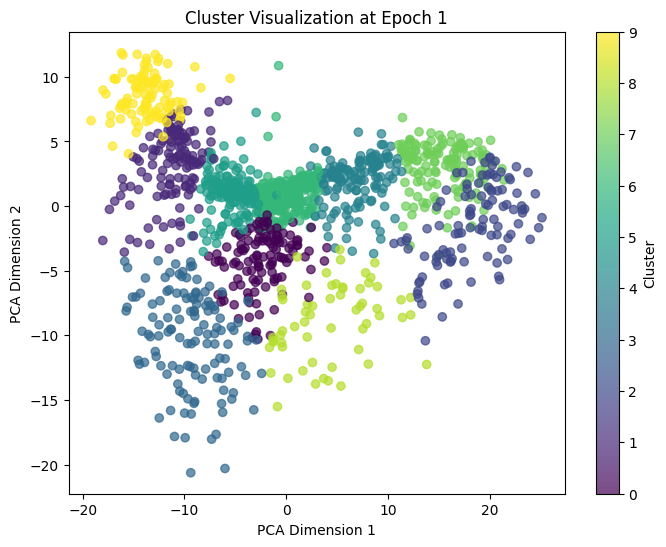

Epoch 2/10: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]


Epoch 2, Loss: 2.5083
Epoch 2, Silhouette Score: 0.3038


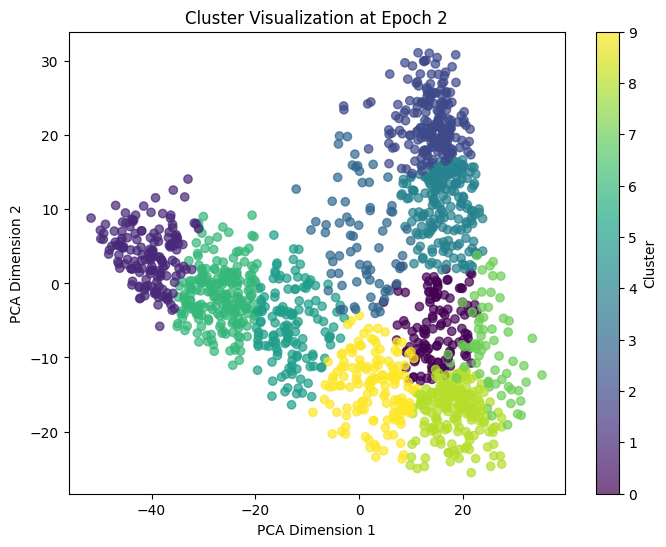

Epoch 3/10: 100%|██████████| 48/48 [00:35<00:00,  1.33it/s]


Epoch 3, Loss: 2.5695
Epoch 3, Silhouette Score: 0.3042


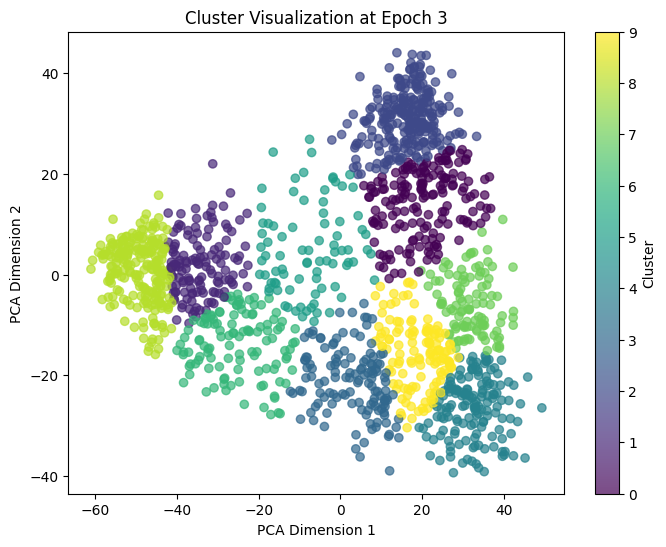

Epoch 4/10: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]


Epoch 4, Loss: 2.5422
Epoch 4, Silhouette Score: 0.3240


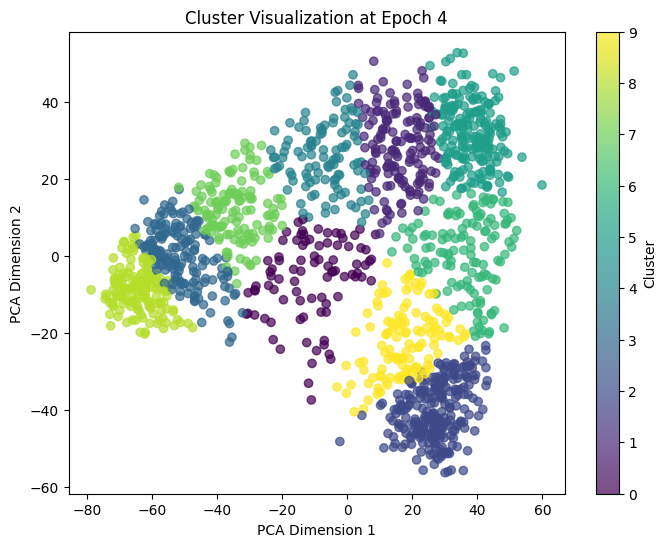

Epoch 5/10: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]


Epoch 5, Loss: 2.5558
Epoch 5, Silhouette Score: 0.3253


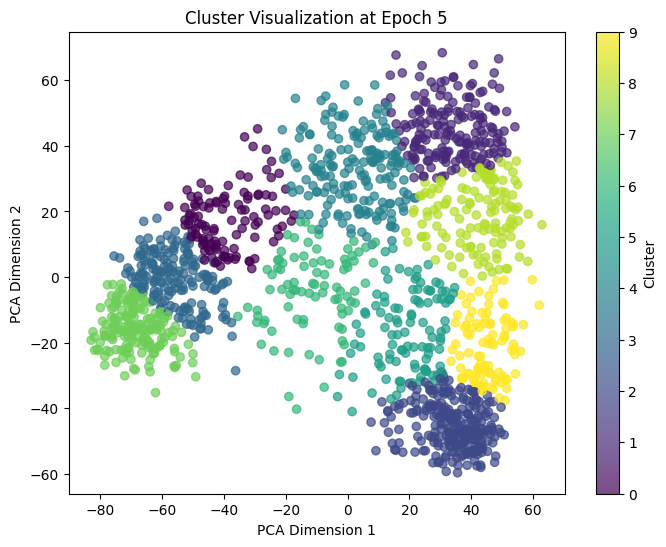

Epoch 6/10: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]


Epoch 6, Loss: 2.5320
Epoch 6, Silhouette Score: 0.3445


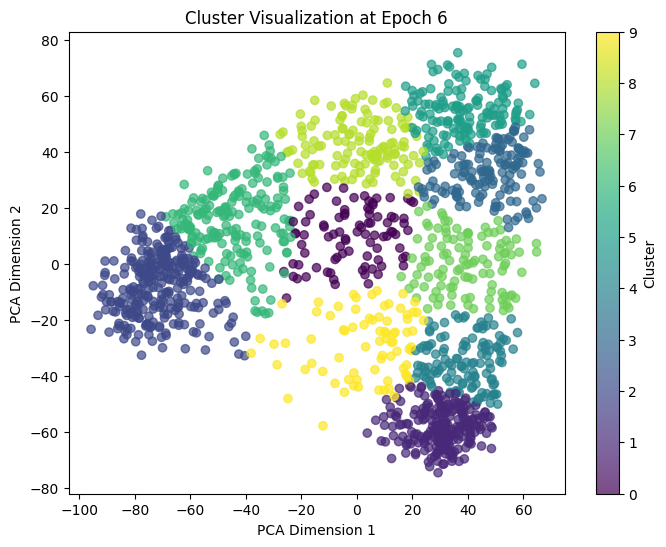

Epoch 7/10: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]


Epoch 7, Loss: 2.5293
Epoch 7, Silhouette Score: 0.3623


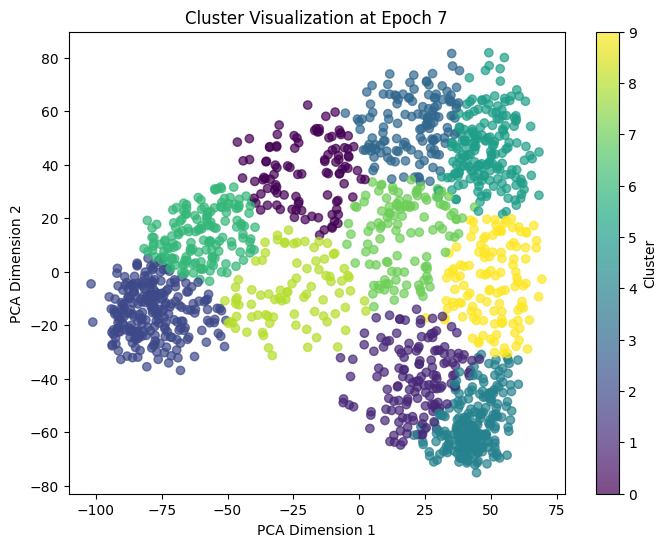

Epoch 8/10: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]


Epoch 8, Loss: 2.5235
Epoch 8, Silhouette Score: 0.3429


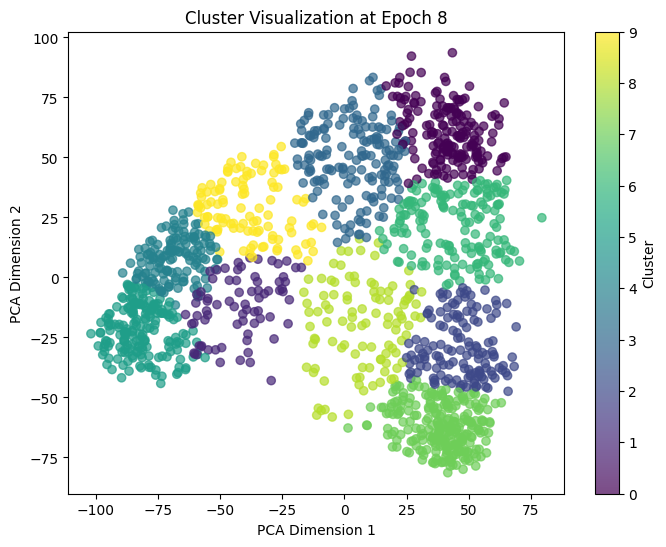

Epoch 9/10: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]


Epoch 9, Loss: 2.5041
Epoch 9, Silhouette Score: 0.3523


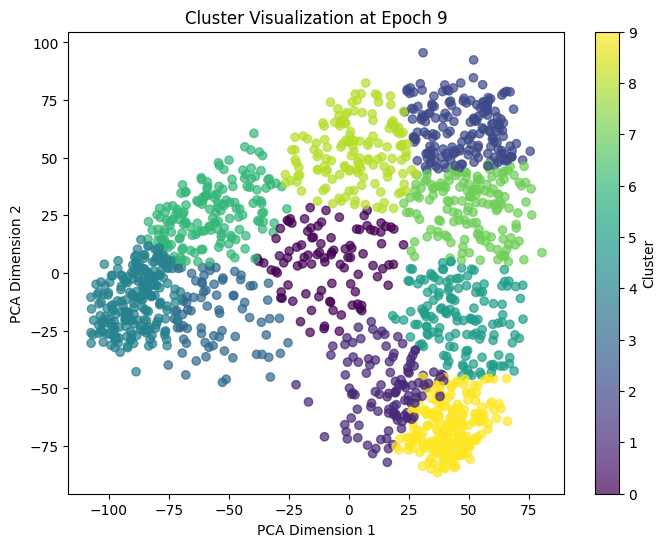

Epoch 10/10: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]


Epoch 10, Loss: 2.5262
Epoch 10, Silhouette Score: 0.3423


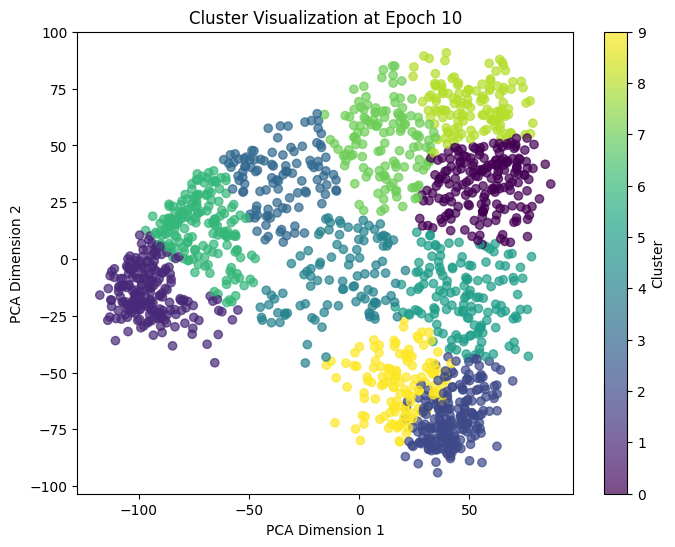

In [8]:
# Define the DCSC Model
class DCSCModel(nn.Module):
    def __init__(self, roberta_model, embedding_dim=768, num_clusters=10):
        super(DCSCModel, self).__init__()
        self.encoder = roberta_model
        self.projection_head = nn.Sequential(
            nn.Linear(embedding_dim, 256), nn.ReLU(), nn.Linear(256, 128)
        )
        self.clustering_head = nn.Linear(128, num_clusters)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            encoded = self.encoder.roberta(
                input_ids=input_ids, attention_mask=attention_mask
            )
        embeddings = self.projection_head(encoded.last_hidden_state[:, 0, :])
        cluster_logits = self.clustering_head(embeddings)
        return embeddings, cluster_logits


# Loss Functions
def contrastive_loss(embeddings, temperature=0.5):
    """
    Computes the contrastive loss using normalized embeddings.
    """
    # Replace NaN values in embeddings with zeros
    embeddings = torch.nan_to_num(embeddings, nan=0.0)

    # Move embeddings to CPU and convert to NumPy
    embeddings_np = embeddings.detach().cpu().numpy()

    # Normalize using sklearn
    embeddings_np = normalize(embeddings_np + 1e-10, axis=1)

    # Convert normalized embeddings back to Torch tensor
    embeddings_normalized = torch.tensor(embeddings_np, dtype=torch.float32).to(
        embeddings.device
    )

    # Compute the similarity matrix
    similarity_matrix = (
        torch.matmul(embeddings_normalized, embeddings_normalized.T) / temperature
    )

    # Create labels for contrastive loss
    labels = torch.arange(similarity_matrix.size(0)).to(similarity_matrix.device)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(similarity_matrix, labels)
    return loss


def clustering_loss(cluster_logits, target_distribution):
    """
    Computes clustering loss using KL divergence between predicted and target distributions.
    """
    pred_distribution = torch.clamp(
        torch.softmax(cluster_logits, dim=1), 
        min=1e-10, 
        max=1 - 1e-10
    )

    kl_div = torch.sum(
        target_distribution
        * torch.log(target_distribution / pred_distribution + 1e-10),
        dim=1,
    )
    return kl_div.mean()


# Target Distribution Update
def update_target_distribution(cluster_logits):
    pred_distribution = torch.softmax(cluster_logits, dim=1).detach()
    weight = pred_distribution**2 / torch.sum(pred_distribution, dim=0)
    return (weight.T / torch.sum(weight, dim=1)).T


# Initialize Components
num_clusters = 10
config = RobertaConfig.from_pretrained("./optimized_roberta_model")
pretrained_roberta = WeightedRobertaForSequenceClassification.from_pretrained(
    "./optimized_roberta_model", config=config
)
dcsc_model = DCSCModel(pretrained_roberta, num_clusters=num_clusters).to(device)
optimizer = optim.Adam(dcsc_model.parameters(), lr=3e-4)

# Create DataLoader for Training
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator
)

# Training Loop
epochs = 10
temperature = 0.5
lambda_clustering = 0.5

for epoch in range(epochs):
    dcsc_model.train()
    total_loss = 0
    embeddings_list = []
    cluster_logits_list = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        optimizer.zero_grad()

        # Forward pass
        embeddings, cluster_logits = dcsc_model(input_ids, attention_mask)

        # Store embeddings and logits for clustering update
        embeddings_list.append(embeddings.detach().cpu())
        cluster_logits_list.append(cluster_logits.detach().cpu())

        # Compute losses
        c_loss = contrastive_loss(embeddings, temperature)
        t_distribution = update_target_distribution(cluster_logits)
        k_loss = clustering_loss(cluster_logits, t_distribution)

        # Combine losses
        loss = c_loss + lambda_clustering * k_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dcsc_model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Perform KMeans Clustering
    all_embeddings = torch.cat(embeddings_list).numpy()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(all_embeddings)
    cluster_assignments = kmeans.labels_

    # Update target distributions with KMeans results
    target_distribution = update_target_distribution(
        torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
    )

    # Calculate and Print Silhouette Score
    silhouette_avg = silhouette_score(all_embeddings, cluster_assignments)
    print(f"Epoch {epoch+1}, Silhouette Score: {silhouette_avg:.4f}")

    # Visualize Clusters
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=cluster_assignments,
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(scatter, label="Cluster")
    plt.title(f"Cluster Visualization at Epoch {epoch+1}")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.show()

# Save Model and Assignments
torch.save(dcsc_model.state_dict(), "./dcsc_model.pth")
np.save("cluster_assignments.npy", cluster_assignments)

Now the pre-trained RoBERTa transformer model create the initial embeddings to train a custom Deep Clustering by Semantic Contrastive Learning (DCSC) model for advanced clustering of Reddit data for sentiment analysis. The goal is to leverage RoBERTa’s language understanding capabilities to generate high-quality embeddings, which are subsequently refined and used for clustering via contrastive and clustering losses. This process involves multiple steps, beginning with data preprocessing, followed by initializing the clustering model, and culminating in a training process that alternates between embedding updates and clustering refinement.

Text data from the full Reddit dataset is preprocessed using tokenization and lemmatization to standardize the input and remove noise. The cleaned text is then tokenized using the RoBERTa tokenizer, which converts the textual data into numerical representations that the model can process. These tokenized representations are padded and truncated to ensure uniform input sizesl.

The pre-trained RoBERTa model, which was fine-tuned in our supervised sentiment analysis, is incorporated into the DCSC model as its encoder. The `DCSCModel` class builds upon the RoBERTa encoder by adding two additional components: a projection head and a clustering head. The projection head reduces the dimensionality of the embeddings produced by the RoBERTa encoder, enabling the model to focus on the most critical features. Meanwhile, the clustering head generates logits representing cluster assignments for the data. These logits are used to refine the clustering process during training.

The training process begins by generating initial embeddings using the RoBERTa encoder. These embeddings are extracted for all data points in the dataset using the DCSC model’s forward method. Once the embeddings are obtained, K-Means clustering is applied to group the data into a predefined number of clusters, artibrarily selected as 10. This clustering step provides an initial distribution of cluster assignments, which serves as the starting point for further refinement during training.

The training loop incorporates both contrastive and clustering loss functions to refine the embeddings and cluster assignments. The contrastive loss encourages similar embeddings to move closer together while pushing dissimilar ones further apart. This loss is computed using normalized embeddings, which are compared using cosine similarity to generate a similarity matrix. Labels derived from the batch indices guide the loss computation, ensuring that the embeddings align with their respective clusters. The clustering loss, on the other hand, minimizes the divergence between the current cluster probabilities and the target distribution derived from K-Means clustering. This loss uses the Kullback-Leibler divergence to ensure that the model aligns its cluster assignments with the optimal distribution over time.

Throughout training, the optimizer updates the model’s parameters to reduce the combined loss, which balances the contributions of contrastive and clustering losses using a weighting factor of lambda = 0.5. Periodically, the embeddings are recomputed, and K-Means clustering is reapplied to update the target distribution. This iterative process ensures that the clustering assignments improve as the model refines the embeddings. By the end of training, the model produces high-quality embeddings that are both semantically meaningful and aligned with distinct clusters.


# Results

The Naive Bayes model provided a baseline for sentiment classification, achieving moderate accuracy. While interpretable, its reliance on simple bag-of-words features limited its ability to capture nuanced sentiment patterns, particularly in complex or ambiguous texts. In contrast, the RoBERTa model significantly outperformed Naive Bayes in both accuracy and recall, demonstrating its capacity to handle the intricacies of natural language and its contextual dependencies.

Using RoBERTa embeddings for clustering, the K-Means algorithm revealed distinct sentiment clusters, albeit with some overlap due to the inherent noise in user-generated content. The DCSC model further refined these clusters, leveraging contrastive learning to enhance separation and coherence. Subsequent topic modeling with LDA provided a dynamic view of the themes within each cluster, highlighting key issues such as workplace conditions, union activism, and labor rights advocacy.

Preliminary findings indicate a positive correlation between subreddit affiliations and sentiment trends. Communities like "antiwork" and "WorkReform" showed overwhelmingly pro-union sentiments, while subreddits like "Conservative" presented more mixed views. This analysis underscores the value of combining supervised and unsupervised learning techniques to unravel complex narratives within large, unstructured datasets.

In [9]:
# Naive Bayes Test Set Accuracy
accuracy_nb = accuracy_score(y_test_decoded_nb, custom_nb_pred)
print(f"Naive Bayes Test Set Accuracy: {accuracy_nb}")

# Detailed performance metrics
print("Naive Bays Classification Report:")
print(
    classification_report(
        y_test_decoded_nb,
        custom_nb_pred,
        target_names=list(map(str, encoder.classes_)),
        zero_division=0,
    )
)

Naive Bayes Test Set Accuracy: 0.6026490066225165
Naive Bays Classification Report:
              precision    recall  f1-score   support

    negative       0.32      0.17      0.22        53
     neutral       0.63      0.61      0.62       114
    positive       0.63      0.77      0.70       135

    accuracy                           0.60       302
   macro avg       0.53      0.52      0.51       302
weighted avg       0.58      0.60      0.58       302



In [ ]:
# Label with RoBERTa
def predict_with_roberta(text):
    roberta_model.eval()
    inputs = tokenizer(
        text, padding=True, truncation=True, max_length=512, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
        logits = outputs["logits"]
        predicted_label = torch.argmax(logits, axis=1).item()
    decoded_label = encoder.inverse_transform([predicted_label])[0]
    return decoded_label


# Apply Predictions to Full Dataset
reddit["label_rob"] = reddit["text"].apply(predict_with_roberta)

# Save Labeled Dataset
output_csv_path = "./data/master/reddit_labelled_new.csv"
output_pkl_path = "./data/pickle/reddit_labelled_new.pkl"
reddit.to_csv(output_csv_path, index=False)
joblib.dump(reddit_full, output_pkl_path)

In [10]:
## roBERTa Test Set Accuracy
print(f"Test Accuracy: {accuracy_score(decoded_labels, decoded_preds):.4f}")

# Classification report
print("RoBERTa Classification Report:")
print(classification_report(decoded_labels, 
                            decoded_preds, 
                            zero_division=0))

Saving predictions to ./data/master/reddit_labelled_new.csv and ./data/pickle/reddit_labelled_new.pkl...
RoBERTa training, evaluation, and labeling complete.
Test Accuracy: 0.6821
RoBERTa Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.67      0.57        55
     neutral       0.80      0.68      0.73       115
    positive       0.71      0.69      0.70       132

    accuracy                           0.68       302
   macro avg       0.66      0.68      0.67       302
weighted avg       0.70      0.68      0.69       302



Analysis comparing the two approaches, their similarities and differences, and their successes and failures.

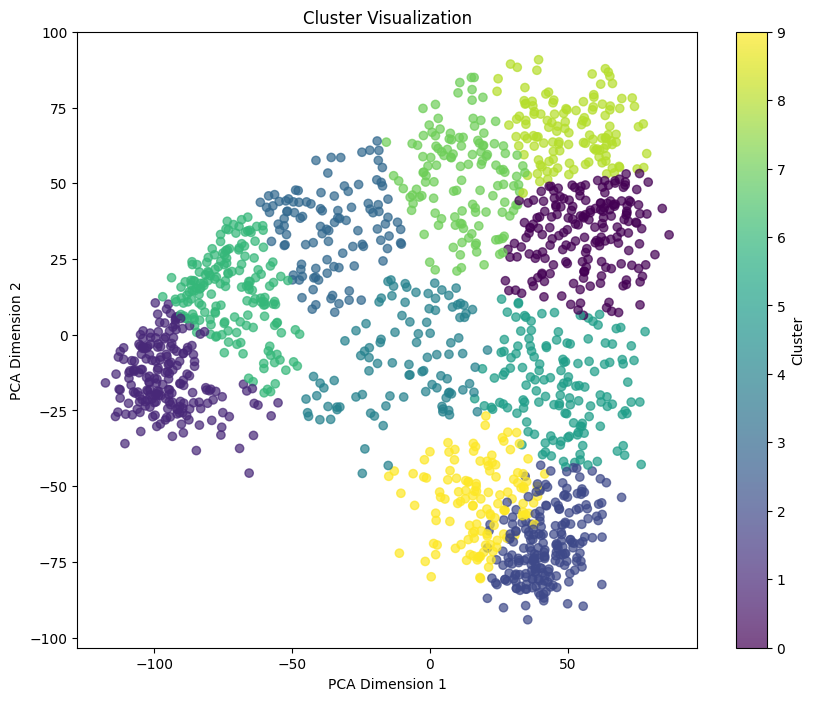

In [11]:
# Visualize Clusters
# Reduce dimensions for visualization using PCA
def visualize_clusters(embeddings, cluster_assignments, title="Cluster Visualization"):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=cluster_assignments,
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(scatter, label="Cluster")
    plt.title(title)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.show()


all_embeddings_np = all_embeddings  # Ensure embeddingsare stored
visualize_clusters(all_embeddings_np, cluster_assignments)

In [ ]:
# Keyword Extraction
def extract_keywords(texts, tokenizer, top_n=10):
    all_tokens = [
        token.lower()
        for text in texts
        for token in tokenizer.tokenize(text)
        if token.isalnum()
    ]
    most_common = Counter(all_tokens).most_common(top_n)
    return [word for word, _ in most_common]

# Group texts by cluster
cluster_texts = {i: [] for i in range(num_clusters)}
for text, cluster in zip(reddit["text_processed"], cluster_assignments):
    cluster_texts[cluster].append(text)


for cluster_id, texts in cluster_texts.items():
    keywords = extract_keywords(texts, tokenizer)
    print(f"Cluster {cluster_id} Keywords: {', '.join(keywords)}")

In [13]:
# Compare Naive Bayes and RoBERTa Labels 
# Group labels by cluster
data = pd.DataFrame(
    {
        "text": reddit["text_processed"],
        "label_nb": reddit["nb_label"],
        "label_rob": reddit["label_rob"],
        "cluster": cluster_assignments,
    }
)

# Calculate label distributions within each cluster
label_distribution = data.groupby("cluster")[["label_nb", "label_rob"]].apply(
    lambda x: Counter(zip(x["label_nb"], x["label_rob"]))
)


for cluster_id, labels in label_distribution.items():
    print(f"Cluster {cluster_id} Label Distribution:")
    for (nb_label, rob_label), count in labels.items():
        print(f"  Naive Bayes: {nb_label}, RoBERTa: {rob_label}, Count: {count}")

KeyError: 'label_rob'

### LDA

rewrite the code to print out the topics in each of the clusters

In [15]:
# LDA 
from gensim import corpora
from gensim.models import LdaModel


# Preprocess texts for LDA
def preprocess_texts_lda(texts):

    preprocessed_texts = []
    for text in texts:
        tokens = [word.lower() for word in word_tokenize(text) if word.isalpha()]
        filtered_tokens = [word for word in tokens if word not in STOP_WORDS]
        preprocessed_texts.append(filtered_tokens)
    return preprocessed_texts


# LDA Analysis
for cluster_id, texts in cluster_texts.items():
    # Preprocess texts in the cluster
    preprocessed_texts = preprocess_texts_lda(texts)

    # Create dictionary and corpus
    dictionary = corpora.Dictionary(preprocessed_texts)
    corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42
    )

    # Print top 5 topics for the cluster
    print(f"Cluster {cluster_id} Topics:")
    for idx, topic in lda_model.print_topics(num_words=10):
        print(f"  Topic {idx}: {topic}")

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/seshat/nltk_data'
    - '/Users/seshat/Documents/GitHub/labor_sentiment_analysis/venv/nltk_data'
    - '/Users/seshat/Documents/GitHub/labor_sentiment_analysis/venv/share/nltk_data'
    - '/Users/seshat/Documents/GitHub/labor_sentiment_analysis/venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


# Discussion

# Conclusion

### References